In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader,SubsetRandomSampler
import numpy as np

In [2]:
!rm -r Yolov6-Small/
!git clone https://github.com/amitpant7/Yolov6-Small.git
!cp -r Yolov6-Small/* .
!rm -r Yolov6-Small/*
print('Modules Downloaded')
# !pip install torcheval

Cloning into 'Yolov6-Small'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 71 (delta 38), reused 57 (delta 24), pack-reused 0
Unpacking objects: 100% (71/71), 341.41 KiB | 2.80 MiB/s, done.
Modules Downloaded


## Preparing the Dataloaders and Visualizing the Objects

In [3]:
from torchvision.datasets import VOCDetection
from utils.transform import train_transform, val_transform
from config import *


train_data = VOCDetection(root='./data', year='2012', image_set='train',
                             download=True, transforms=val_transform)

val_data = VOCDetection(root='./data', year='2012', image_set='val',
                             download=True, transforms=val_transform)

train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle = True,
        num_workers=0,
        pin_memory=True,
        drop_last=False,
    )


val_size = len(val_data)
val_indices = np.random.choice(val_size, int(0.35 * val_size), replace=False)
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE, shuffle=False)

# val_loader = torch.utils.data.DataLoader(
#         val_data,
#         batch_size=batch_size,
#         shuffle = False,
#         num_workers=0,
#         pin_memory=True,
#         drop_last=False,
#     )

print('The ImageNet train set is ready. Size : {}'.format(len(train_loader)*batch_size))



dataloaders = dict()

dataloaders['train'] = train_loader
dataloaders['val'] = val_loader

dataset_sizes = {'train': len(train_loader)*batch_size,
                'val': len(val_loader)*batch_size}
print(dataset_sizes)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
The ImageNet train set is ready. Size : 5728
{'train': 5728, 'val': 2048}


In [160]:
#for testing  the correct working of model and see if it can overfit train data or not 
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler
# Create indices for subset

train_size = len(train_data)
val_size = len(val_data)

train_indices = np.random.choice(train_size, int(0.01 * train_size), replace=False)
val_indices = np.random.choice(val_size, int(0.02 * val_size), replace=False)

# Create samplers
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create DataLoaders
train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE, shuffle=False)

# Assign to dataloaders dictionary
dataloaders = {
    'train': train_loader,
    'val': train_loader
}

dataset_sizes = {'train': len(train_loader)*batch_size,
                'val': len(train_loader)*batch_size}
print(dataset_sizes)

{'train': 64, 'val': 64}


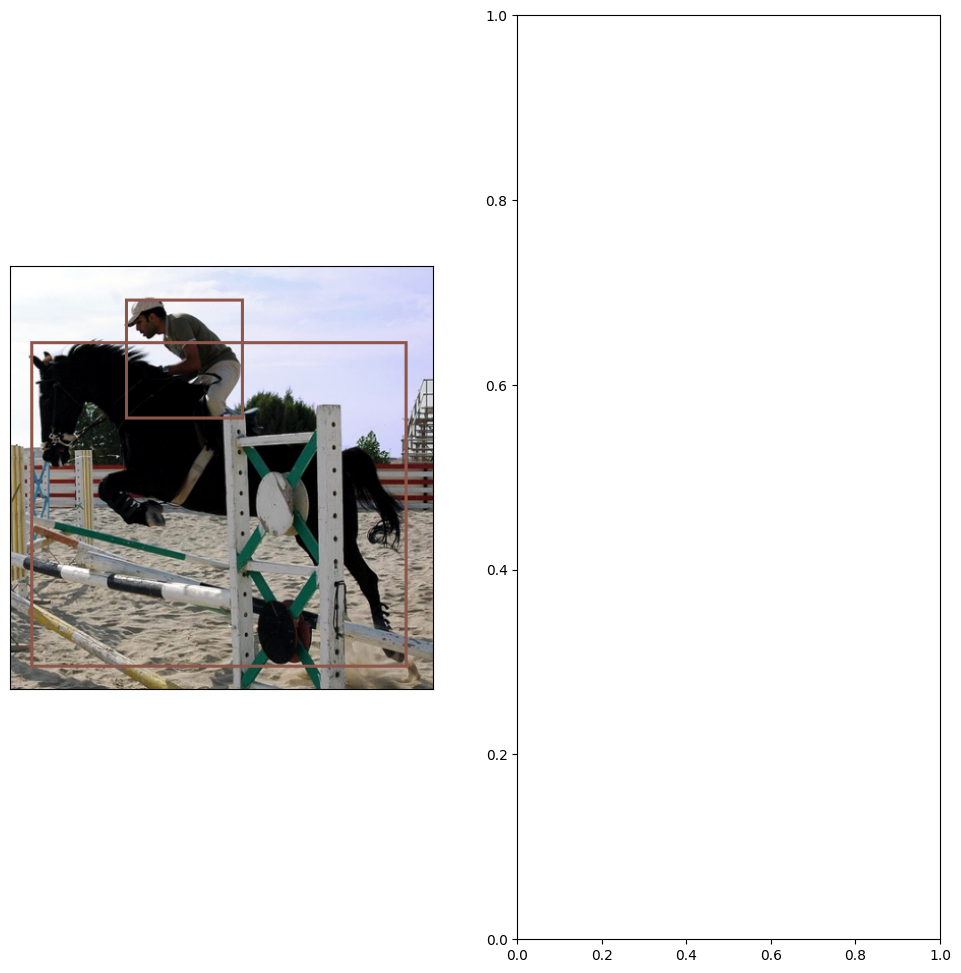

In [5]:
from utils.utils import visualize_bb
from utils.utils import decode_targets

samples  =[]
for i in range(0,1):
# for i in train_indices:
  img , targets = train_data[i]
  target = decode_targets(targets, center_thres=0.8)
  bboxes, labels = target[:, 1:5], target[:, 0]
  # print(bboxes, labels)
  sample = {'image': img, 'bbox':bboxes, 'labels':labels.long()}
  samples+=[sample]


visualize_bb(samples)

## Model Intialization

In [6]:
from yolov6.yolov6 import YOLOv6s
model = YOLOv6s(num_classes=20)
model = model.to(device)

## Loss Function 

In [7]:
def convert_to_xy(pred, img_size = 416):
   """Takes input tensors and converts them into x1y1x2y2 format using center anchors
   """
   s = pred.size(1)
   stride = img_size/s
   range_vals = torch.arange(s, device=device)
   x_grid, y_grid = torch.meshgrid(range_vals, range_vals, indexing='ij')

   pred[..., 0:1] = x_grid.unsqueeze(dim=-1) - pred[..., 0:1]  #x1
   pred[..., 1:2] = y_grid.unsqueeze(dim=-1) - pred[..., 1:2]  #Y1
   pred[..., 2:3] = x_grid.unsqueeze(dim=-1) + pred[..., 2:3]  #x2
   pred[..., 3:4] = y_grid.unsqueeze(dim=-1) + pred[..., 3:4]  #y2
   pred = pred.clamp(min = 0)

   return pred+0.5   #offset

In [132]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from config import device


def calculate_iou(box1, box2, mode=None):
    assert box1.shape == box2.shape
    assert box1.dtype == box2.dtype
    assert mode is not None
    epsilon = 1e-7

#     if mode == "corner":
#         assert torch.all(box1[..., 0] < box1[..., 2]), "box1: x1 must be less than x2"
#         assert torch.all(box1[..., 1] < box1[..., 3]), "box1: y1 must be less than y2"
#         assert torch.all(box2[..., 0] < box2[..., 2]), "box2: x1 must be less than x2"
#         assert torch.all(box2[..., 1] < box2[..., 3]), "box2: y1 must be less than y2"

    if mode == "center":
        x1 = torch.max(
            box1[..., 0:1] - box1[..., 2:3] / 2, box2[..., 0:1] - box2[..., 2:3] / 2
        )
        y1 = torch.max(
            box1[..., 1:2] - box1[..., 3:4] / 2, box2[..., 1:2] - box2[..., 3:4] / 2
        )
        x2 = torch.min(
            box1[..., 0:1] + box1[..., 2:3] / 2, box2[..., 0:1] + box2[..., 2:3] / 2
        )
        y2 = torch.min(
            box1[..., 1:2] + box1[..., 3:4] / 2, box2[..., 1:2] + box2[..., 3:4] / 2
        )
    elif mode == "corner":
        x1 = torch.max(box1[..., 0:1], box2[..., 0:1])
        y1 = torch.max(box1[..., 1:2], box2[..., 1:2])
        x2 = torch.min(box1[..., 2:3], box2[..., 2:3])
        y2 = torch.min(box1[..., 3:4], box2[..., 3:4])
    elif mode == "width_height":
        intersection = torch.min(box1[..., 0], box2[..., 0]) * torch.min(
            box1[..., 1], box2[..., 1]
        )
        union = box1[..., 0] * box1[..., 1] + box2[..., 0] * box2[..., 1] - intersection
        iou = intersection / (union + epsilon)
        return iou
    else:
        raise ValueError("mode should be 'center' or 'corner' or 'width_height'")

    if mode == "corner":
        box1_area = (box1[..., 2:3] - box1[..., 0:1]) * (
            box1[..., 3:4] - box1[..., 1:2]
        )
        box2_area = (box2[..., 2:3] - box2[..., 0:1]) * (
            box2[..., 3:4] - box2[..., 1:2]
        )
    else:  # 'center' mode
        box1_area = box1[..., 2:3] * box1[..., 3:4]
        box2_area = box2[..., 2:3] * box2[..., 3:4]
    # intersection = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)
    intersection = (x2 - x1) * (y2 - y1)
    union = box1_area + box2_area - intersection
    iou = intersection / (union + epsilon)
    # print("intersection: {:.0f}".format(intersection.sum().item()))
    # print("union: {:.0f}".format((union+epsilon).sum().item()))
    # iou2 =intersection.sum().item()/union.sum().item()
    # print("iou: {:.4f}".format(iou2))
    return iou


class IOULoss(nn.Module):
    def __init__(self, mode=None, theta=4):
        """
        SIOU loss : https://arxiv.org/pdf/2205.12740
        CIOU loss : TODO
        GIOU loss : TODO

        Takes input of the format x1, y1, x2, y2
        :param mode:
        """
        super().__init__()
        self.mode = mode
        self.theta = theta

    def forward(self, pred, target):
        """
        pred, target in xyxy format
        :param pred:[bs,grid_size,grid_size,4]
        :param target: [bs,grid_size,grid_size,4]
        :return:
        """
        assert pred.shape == target.shape
        assert pred.dtype == target.dtype
        assert self.mode is not None
  

        epsilon = 1e-10
        mask = target[..., 0] > 0
        
        pred = torch.exp(pred).clone()
        pred = convert_to_xy(pred)
        target = convert_to_xy(target)
        
        pred = pred[mask]
        target = target[mask]
        

        iou = calculate_iou(pred, target, mode=self.mode)
        b1_x1, b1_y1, b1_x2, b1_y2 = pred[...,0],pred[...,1],pred[...,2],pred[...,3]
        b2_x1, b2_y1, b2_x2, b2_y2 = target[...,0],target[...,1],target[...,2],target[...,3]

        w1, h1 = b1_x2 - b1_x1 + epsilon, b1_y2 - b1_y1 + epsilon
        w2, h2 = b2_x2 - b2_x1 + epsilon, b2_y2 - b2_y1 + epsilon
        cw = torch.max(b1_x2, b2_x2) - torch.min(b1_x1, b2_x1) + epsilon
        ch = torch.max(b1_y2, b2_y2) - torch.min(b1_y1, b2_y1) + epsilon

        Cw = ((b2_x1 + b2_x2 - b1_x1 - b1_x2) * 0.5)
        Ch = ((b2_y1 + b2_y2 - b1_y1 - b1_y2) * 0.5)
        sigma = torch.sqrt(Cw**2 + Ch**2+epsilon) 
        
        # sin_alpha = torch.clamp(ch/sigma, -1+epsilon, 1-epsilon)
        # angle_cost = 1 - 2 * torch.pow( torch.sin(torch.arcsin(sin_alpha) - np.pi/4), 2)

        sin_alpha_1 = torch.abs(Cw) / sigma
        sin_alpha_2 = torch.abs(Ch) / sigma
        threshold = np.pi / 4
        sin_alpha = torch.where(sin_alpha_1 > threshold, sin_alpha_2, sin_alpha_1)

        angle_cost = torch.sin(torch.arcsin(sin_alpha) * 2)
        gamma = 2 - angle_cost
        rho_x = (Cw / cw) ** 2
        rho_y = (Ch / ch) ** 2
        distance_cost = (1 - torch.exp(-gamma * rho_x)) + (
            1 - torch.exp(-gamma * rho_y)
        )

        omega_w = torch.abs(w1 - w2) / torch.max(w1, w2)
        omega_h = torch.abs(h1 - h2) / torch.max(h1, h2)
        shape_cost = torch.pow((1 - torch.exp(-omega_w)), self.theta) + (
            torch.pow((1 - torch.exp(-omega_h)), self.theta)
        )
        iou = iou.squeeze(-1) - (distance_cost + shape_cost) * 0.5
        loss = 1 - iou
        # print(f"angle_cost: {angle_cost.sum()}")
        # print(f"shape_cost: {shape_cost.sum()}")
        # print(f"distance_cost: {distance_cost.sum()}")
        # print(f"iou:{iou.sum()}")
#         print('shape:', loss.shape)
        return loss.nanmean()


class VarifocalLoss(nn.Module):
    def __init__(self):
        super(VarifocalLoss, self).__init__()

    def forward(self, preds, targets, alpha=0.75, gamma=2.0):
        """

        :param preds:[bs, grid_size, grid_size,num_classes]
        :param targets:[bs, grid_size, grid_size,num_classes]
        :param alpha:
        :param gamma:
        :return:
        """
        pred_prob = torch.sigmoid(preds)

        weight = alpha * pred_prob.pow(gamma) * (1 - targets) + targets
        with torch.cuda.amp.autocast(enabled=False):
            loss = F.binary_cross_entropy(pred_prob, targets, reduction="none") * weight

            #         loss = F.binary_cross_entropy_with_logits(preds, targets.float(), reduction="none")
        return loss.mean()


class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.lambda_class = 1.5
        self.lambda_iou = 2.5
        self.lambda_center = 1.0

        self.varifocal_loss = VarifocalLoss()
        self.box_loss = IOULoss("corner")

    def forward(self, preds, targets):
        # class loss
        # One-hot encoded labels
        total_loss=0
 
        for pred, target in zip(preds, targets):
           #creating mask to perform cal only where there is object
            loss_iou = self.box_loss(pred[..., 20:24], target[..., 20:24])
            loss_cls = self.varifocal_loss(pred[..., :20], target[..., :20])

            
            mask =  target[..., 24:25]>0
            center_loss = F.binary_cross_entropy_with_logits(pred[..., 24:25][mask], target[..., 24:25][mask])
            
            loss = self.lambda_class * loss_cls + self.lambda_iou * loss_iou + self.lambda_center*center_loss
            total_loss+=loss
        return total_loss



### Trying Giou loss


In [25]:
# import torch
# import torch.nn as nn
# import numpy as np
# import torch.nn.functional as F
# from config import device
# import torchvision


# class IOULoss(nn.Module):
#     def __init__(self, mode=None, theta=4):
#         """
#         SIOU loss : https://arxiv.org/pdf/2205.12740
#         CIOU loss : TODO
#         GIOU loss : TODO

#         Takes input of the format x1, y1, x2, y2
#         :param mode:
#         """
#         super().__init__()
#         self.mode = mode
#         self.theta = theta

#     def forward(self, pred_in, target):
#         """
#         pred, target in xyxy format
#         :param pred:[bs,grid_size,grid_size,4]
#         :param target: [bs,grid_size,grid_size,4]
#         :return:
#         """

#         epsilon = 1e-10
    
#         mask = target[..., 0] > 0
#         pred = torch.exp(pred_in).clone()
#         pred = convert_to_xy(pred)
        
#         target = convert_to_xy(target)
        
#         ious = torchvision.ops.complete_box_iou(pred[mask], target[mask])
#         loss = 1 - ious    
#         return loss.nanmean()


# # class VarifocalLoss(nn.Module):
# #     def __init__(self):
# #         super(VarifocalLoss, self).__init__()

# #     def forward(self, preds, targets, alpha=0.75, gamma=2.0):
# #         """

# #         :param preds:[bs, grid_size, grid_size,num_classes]
# #         :param targets:[bs, grid_size, grid_size,num_classes]
# #         :param alpha:
# #         :param gamma:
# #         :return:
# #         """
# #         pred_prob = torch.sigmoid(preds)

# #         weight = alpha * pred_prob.pow(gamma) * (1 - targets) + targets
# #         with torch.cuda.amp.autocast(enabled=False):
# #             loss = F.binary_cross_entropy(pred_prob, targets, reduction="none") * weight

# #             #         loss = F.binary_cross_entropy_with_logits(preds, targets.float(), reduction="none")
# #         return loss.mean()

# class FocalLoss(nn.Module):
#     def __init__(self, gamma):
#         super().__init__()
#         self.ce_loss = nn.BCEWithLogitsLoss(reduction="none")
#         self.gamma = gamma

#     def forward(self, pred, target):
#         pred = pred.permute(0, 3, 1,  2)
#         target = target.permute(0, 3, 1, 2)
#         ce_loss = self.ce_loss(pred, target)
        
#         pred_prob = torch.sigmoid(pred)

#         # pt pt=true×pred_prob+(1−true)×(1−pred_prob).
#         pt = target * pred_prob + (1 - target) * (1 - pred_prob)
#         coeff = (1 - pt) ** self.gamma

#         focal_loss = ce_loss * coeff
#         return focal_loss.nanmean()


# class CustomLoss(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.lambda_class = 1.0
#         self.lambda_iou = 2.5
#         self.lambda_center = 1.0

#         self.varifocal_loss = FocalLoss(gamma=2)
#         self.box_loss = IOULoss("corner")

#     def forward(self, preds, targets):
#         # class loss
#         # One-hot encoded labels
#         total_loss=0
 
#         for pred, target in zip(preds, targets):
#            #creating mask to perform cal only where there is object
    
            
#             loss_iou = self.box_loss(pred[..., 20:24], target[..., 20:24])
#             loss_cls = self.varifocal_loss(pred[..., :20], target[..., :20])
            
            
#             mask =  target[..., 24:25]>0
#             center_loss = F.binary_cross_entropy_with_logits(pred[..., 24:25][mask], target[..., 24:25][mask])


#             loss = self.lambda_class * loss_cls + self.lambda_iou * loss_iou + self.lambda_center*center_loss
            
# #             print(loss_cls, loss_iou)
#             total_loss+=loss
#         return total_loss



In [10]:
out = model(img.unsqueeze(0).to(device))
targets = [t.unsqueeze(0).to(device) for t in targets]

#### criterion = CustomLoss()
criterion(out, targets)

## Model Training

In [163]:
#loss function 
criterion = CustomLoss()

model = YOLOv6s(num_classes=20)
model = model.to(device)

model = model.to(device)

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.Adam(model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
# scheduler = MultiStepLR(optimizer, milestones=[10,25,40, 60], gamma=0.1)
exp_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer_ft, milestones=[70,110], gamma=0.1)

In [183]:
from yolov6.train import train_model
torch.autograd.set_detect_anomaly(True)

model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, 
                    dataloaders, dataset_sizes, num_epochs=20)

Epoch 1/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 5.6076


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 5.7564

Epoch 2/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: nan


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 5.4323

Epoch 3/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 5.3602


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 5.0729

Epoch 4/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 5.3818


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 5.1655

Epoch 5/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 5.2424


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 5.1452

Epoch 6/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 5.2056


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 5.1870

Epoch 7/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 5.3507


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 5.2016

Epoch 8/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 5.2422


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 5.0926

Epoch 9/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 5.3051


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 5.1199

Epoch 10/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 5.4134


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 5.0938

Epoch 11/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 5.2267


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 5.1088

Epoch 12/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 5.2488


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 5.3128

Epoch 13/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 5.2040


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 5.0845

Epoch 14/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: nan


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 4.8424

Epoch 15/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 4.8957


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 4.8608

Epoch 16/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 5.0626


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 4.9338

Epoch 17/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 4.9416


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 4.7917

Epoch 18/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 5.0353


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 4.8647

Epoch 19/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 5.0815


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 5.0481

Epoch 20/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

train Loss: 4.9949


  0%|          | 0/4 [00:00<?, ?it/s]

val Loss: 5.1004

Model with Best mAP: 0
Training complete in 16m 39s


## Model Inference and Testing 

In [104]:
torch.save(model, 'model_working.pth')

### Visualizing the model outputs

In [184]:
import torch

def decode_preds(targets, nc=20, scales=[13, 26, 52], img_size=416, center_thres=0, conf_thres=0.8):
    """
    Decode predictions from the model output tensor(s) into bounding boxes. 

    Args:
    - targets (list of torch.Tensor): List of tensors representing model outputs for each scale.
                                      Each tensor has shape [1, scale, scale, nc + 5].
    - nc (int): Number of classes.
    - scales (list): List of scales at which predictions are made.
    - img_size (int): Size of the input image.
    - center_thres (float): Threshold for centerness score to keep a bounding box., #not used righ now
    - conf_thres (float): Threshold for confidence score to consider a class assignment.

    Returns:
    - torch.Tensor: Decoded bounding boxes with shape [N, 7], where N is the number of valid bounding boxes.
                    Each row represents [class_label, confidence_score, center_x, center_y, width, height, centerness].

    """
    outputs = []

    for tensor, scale in zip(targets, scales):
        # Since batch size is always 1, we can remove the batch dimension directly
        tensor = tensor.squeeze(0)  # Shape [scale, scale, nc + 5]

        stride = img_size / scale
        cls = torch.sigmoid(tensor[..., :nc])  # Class assignments
        reg = tensor[..., nc:]  # Regression info including centerness
        reg[..., :4] = torch.exp(reg[..., :4])
#         reg[..., :4] = (torch.sigmoid(reg[..., :4]) * 2) ** 3
        
        # Find positions where class assignments are made (any class score > conf_thres)
        class_mask = cls > conf_thres
        class_indices = torch.nonzero(class_mask, as_tuple=False)

        # Extract class labels and positions
        labels = class_indices[:, 2]  # Class indices
        i_indices = class_indices[:, 0]  # Grid i positions
        j_indices = class_indices[:, 1]  # Grid j positions

        # Gather regression values using advanced indexing
        cls_conf = cls[class_mask]
        reg_values = reg[i_indices, j_indices, :]
        
        l, t, r, b, centerness = reg_values.T
        l, t, r, b = l * stride, t * stride, r * stride, b * stride

        center_x = (i_indices.float() + 0.5) * stride
        center_y = (j_indices.float() + 0.5) * stride

        left = center_x - l
        top = center_y - t
        right = center_x + r
        bottom = center_y + b

        # Calculate the original coordinates
        centers = (left + right) / 2, (top + bottom) / 2

        widths = right - left
        heights = bottom - top
        
        centerness = torch.sigmoid(centerness)

        # Create bounding boxes
        bboxes = torch.stack(
            [labels.float(),cls_conf, centers[0], centers[1], widths, heights, centerness], dim=1
        )
        

        keep = bboxes[..., -1] >= center_thres

        if bboxes[keep].size(0) > 0:
            outputs.extend(bboxes[keep].tolist())

    return torch.tensor(outputs).clamp_(min=0)


In [185]:
from utils.utils import convert_to_corners
import torchvision

def non_max_suppression(boxes, scores, io_threshold):
    """
    Perform non-maximum suppression to eliminate redundant bounding boxes based on their scores.

    Args:
        boxes (Tensor): Tensor of shape (N, 4) containing bounding boxes in the format (x_center, y_center, width, height).
        scores (Tensor): Tensor of shape (N,) containing confidence scores for each bounding box.
        threshold (float): Threshold value for suppressing overlapping boxes.

    Returns:
        Tensor: Indices of the selected bounding boxes after NMS.
    """
    # Convert bounding boxes to [x_min, y_min, x_max, y_max] format
    boxes = convert_to_corners(boxes)
    #     print(boxes)

    # Apply torchvision.ops.nms
    keep = torchvision.ops.nms(boxes, scores, io_threshold)

    return keep


torch.Size([2])
torch.Size([3])
torch.Size([1])
torch.Size([3])
torch.Size([3])
torch.Size([2])


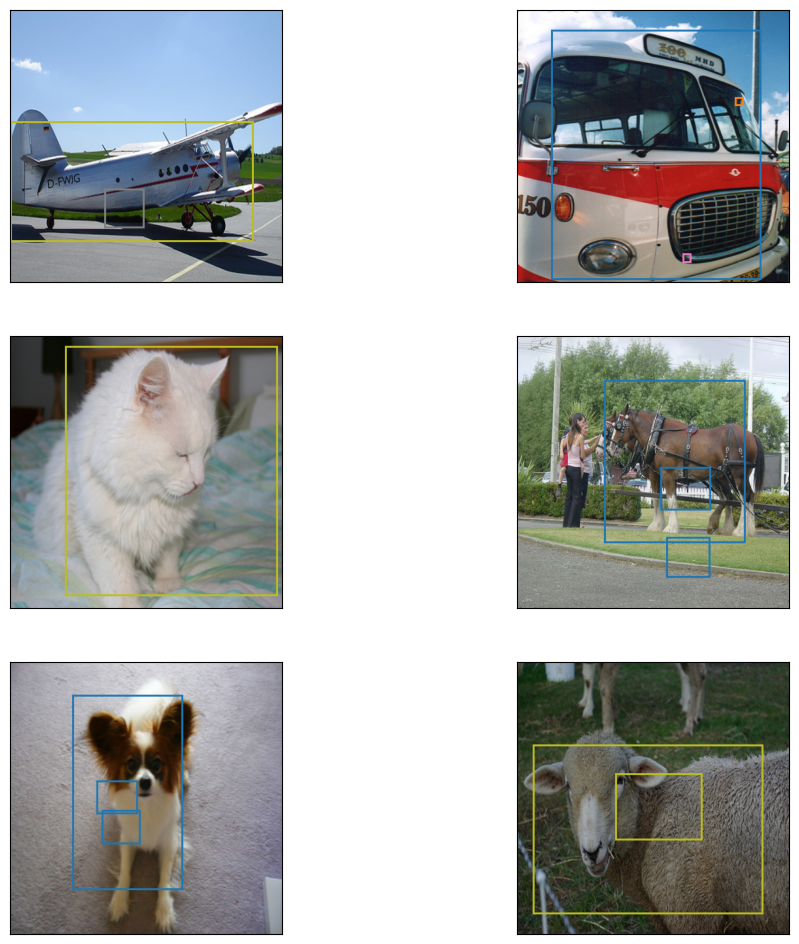

In [192]:

samples = []
model.eval()
ind =  np.random.choice(train_indices, size=10, replace=False)
for indices in ind:
    img = train_data[indices][0]
    image = img.unsqueeze(0)
    image = image.to(device)
    preds = model(image)
    outputs = decode_preds(preds, center_thres=0.65, conf_thres=0.6)
    
    if outputs.dim()<=1:
        continue

    labels, conf, bboxes,  =outputs[:, 0], outputs[:, 1], outputs[:, 2:6]
    keep = non_max_suppression(bboxes.clone(), conf, 0.2)
    print(keep.shape)


    sample = {'image': img, 'bbox':bboxes[keep], 'labels':labels[keep].long()}
    samples+=[sample]

visualize_bb(samples)